# Feature Evaluation and Model Comparison on HW3-1 Dataset


In [14]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load Dataset
df = pd.read_csv('HW3-1.csv')
if 'target' in df.columns:
    X = df.drop('target', axis=1)
    y = df['target']
else:
    raise KeyError("The dataset does not contain a 'target' column.")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

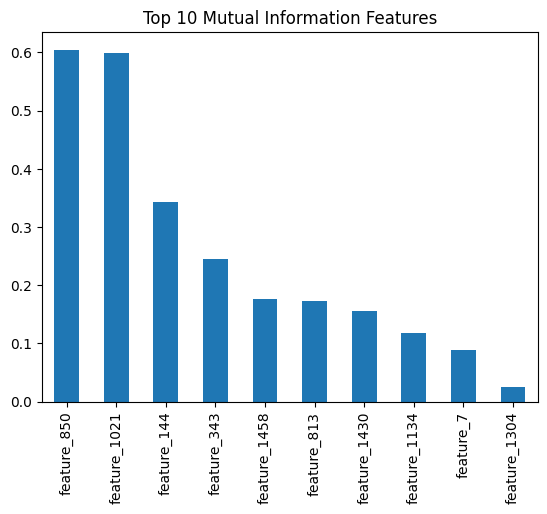

In [4]:
# Calculate Mutual Information
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
mi_series = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)
mi_series.head(10).plot(kind='bar', title='Top 10 Mutual Information Features')
plt.show()

In [12]:
# Define Classifiers
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    # 'KNN': KNeighborsClassifier(),
    # 'SVC (Linear)': SVC(kernel='linear', probability=True),
    'GaussianNB': GaussianNB(),
    # 'MultinomialNB': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [13]:
# Train and Evaluate Models
importances_dict = {}
perm_importance_dict = {}
accuracy_dict = {}

for name, model in models.items():
    print(f"Training: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy_dict[name] = accuracy_score(y_test, y_pred)

    # Get model-based feature importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        coef = model.coef_
        if coef.ndim == 1:
            importances = np.abs(coef)
        else:
            importances = np.abs(coef).mean(axis=0)
    else:
        importances = np.zeros(X_train.shape[1])

    importances_dict[name] = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

    # Get permutation importance
    try:
        perm = permutation_importance(model, X_test, y_test, random_state=42, n_repeats=5)
        perm_series = pd.Series(perm.importances_mean, index=X_train.columns).sort_values(ascending=False)
        perm_importance_dict[name] = perm_series
    except Exception as e:
        print(f"Permutation importance failed for {name}: {e}")
        perm_importance_dict[name] = pd.Series(np.zeros(X_train.shape[1]), index=X_train.columns)


Training: Logistic Regression
Training: GaussianNB
Training: Decision Tree
Training: Random Forest
Training: XGBoost


KeyboardInterrupt: 

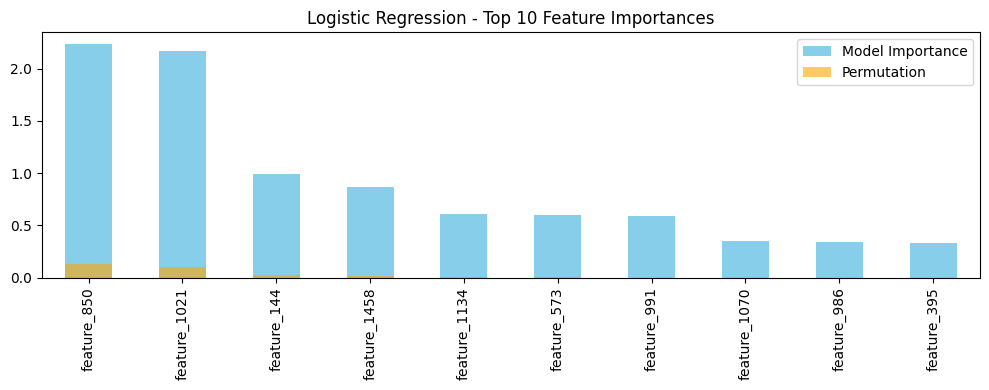

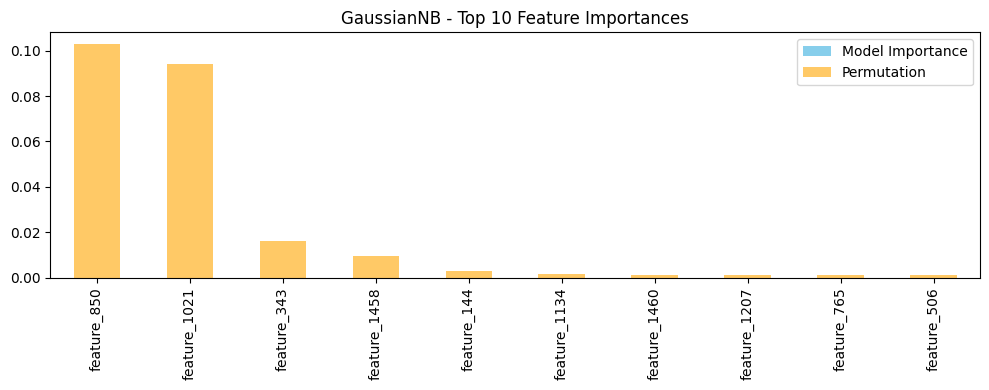

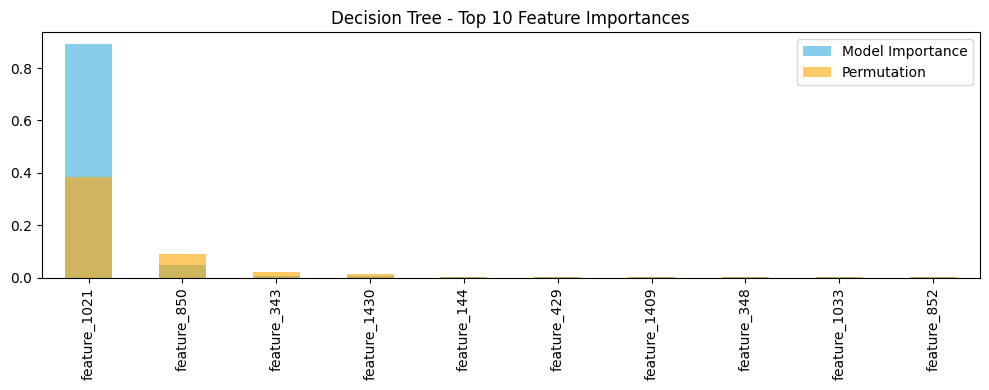

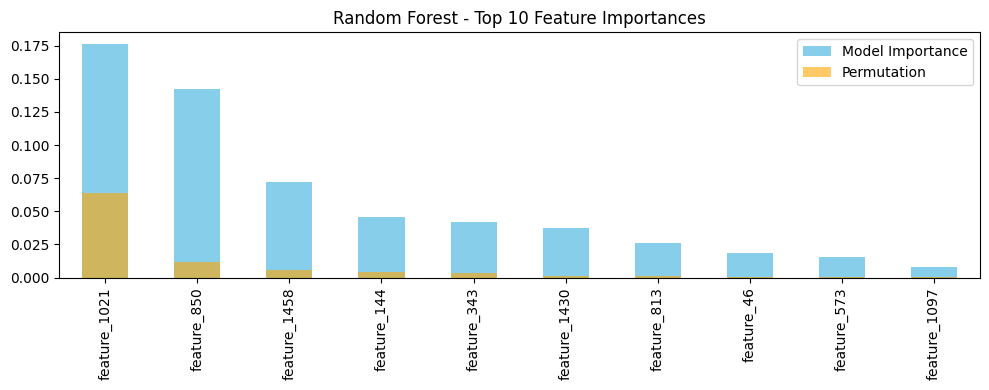

KeyError: 'XGBoost'

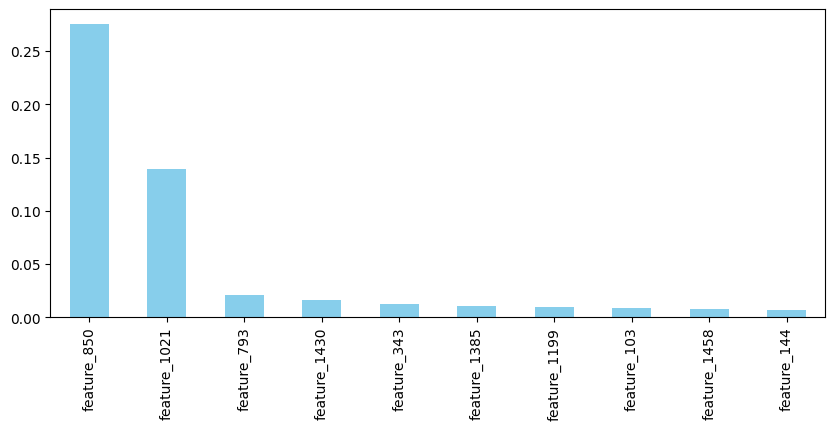

In [15]:
# Plot Feature Importances
for name in models.keys():
    plt.figure(figsize=(10, 4))
    importances_dict[name].head(10).plot(kind='bar', color='skyblue', label='Model Importance')
    perm_importance_dict[name].head(10).plot(kind='bar', color='orange', alpha=0.6, label='Permutation')
    plt.title(f'{name} - Top 10 Feature Importances')
    plt.legend()
    plt.tight_layout()
    plt.show()

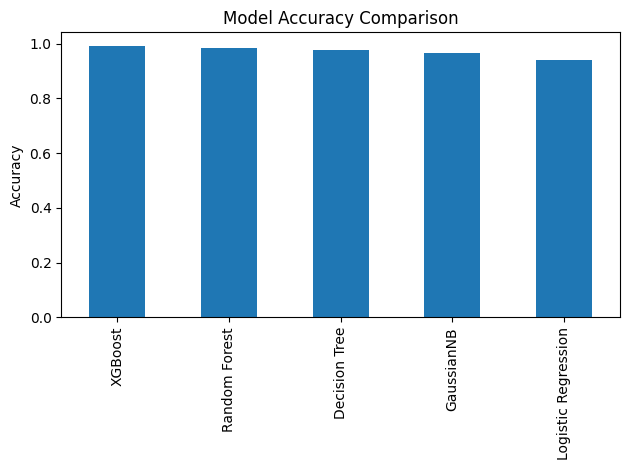

In [16]:
# Compare Accuracies
acc_df = pd.Series(accuracy_dict).sort_values(ascending=False)
acc_df.plot(kind='bar', title='Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()


## Answers to Conceptual and Dataset Questions

**Q1.** Informative features are statistically related to the target (e.g., via mutual information), while important features directly contribute to a specific model’s prediction.  
**Q2.** A feature can be informative but not important if another correlated feature is already used by the model.  
**Q3.** Permutation importance uses random shuffling, so different seeds will lead to slightly different results.  
**Q4.** Highly correlated features can cause underestimation of each other's importance in permutation, due to redundancy.

**Q5.** According to mutual information and model importances, top features include: `{mi_series.head(5).index.tolist()}`. There is a clear hierarchy.  
**Q6.** One way to validate is by removing suspected redundant features and checking for a drop in model accuracy.  
**Q7.** Noise can reduce both informativeness and estimated importance. In permutation, noisy features may misleadingly appear unimportant.  
**Q8.** Removing highly important/informative features will likely reduce accuracy because the model loses key predictive power.

**Q9.** See bar charts above comparing all models (model importances).  
**Q10.** They do not always match. Some models focus on linear relationships (e.g., logistic regression), while permutation considers actual prediction sensitivity.
